# LeNet – Convolutional Neural Network in Python

## About

### The LeNet architecture was first introduced by LeCun et al. in their 1998 paper, Gradient-Based Learning Applied to Document Recognition.As the name of the paper suggests, the authors’ implementation of LeNet was used primarily for OCR and character recognition in documents.

### The LeNet architecture is straightforward and small, (in terms of memory footprint), making it perfect for teaching the basics of CNNs — it can even run on the CPU (if your system does not have a suitable GPU), making it a great “first CNN”.




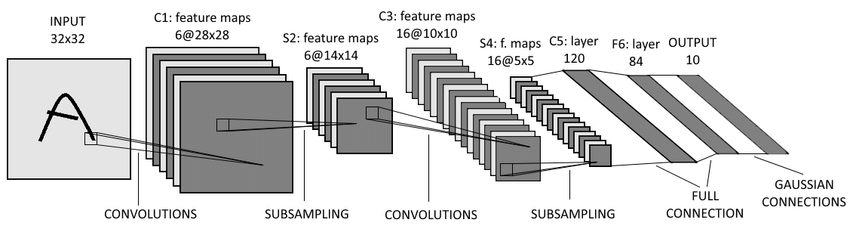

### In this notebook we will try to recreate LE-NET from scratch.

# Architecture Summary of LeNet

```
LeNet Architecture
f=filter,s=stride,p=padding
1*32*32 Input -> f(5*5),s = 1,p= 0 -> avg pool s=2,p=0 -> f(5*5),s=1,p=0 -> avg pool s=2,p=0
-> Conv 5*5 to 120 channels x Linear 84 x linear 10
```

In [1]:
# Imports
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
from torch.utils.data import (
    DataLoader,
)  # Gives easier dataset managment and creates mini batches
import torchvision.datasets as datasets  # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms  # Transformations we can perform on our dataset

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=(2,2),stride=(2,2))
        self.conv1 = nn.Conv2d(in_channels=1,out_channels =6,kernel_size=(5,5),stride=(1,1),padding=(0,0))
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=(5,5),stride=(1,1),padding=(0,0))
        self.conv3 = nn.Conv2d(in_channels=16,out_channels=120,kernel_size=(5,5),stride=(1,1),padding=(0,0))
        self.linear1 = nn.Linear(120,84)
        self.linear2 = nn.Linear(84,10)
        

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(
            self.conv3(x)
        )  # num_examples x 120 x 1 x 1 --> num_examples x 120
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [3]:
def test_lenet():
    x = torch.randn(64, 1, 32, 32)
    model = LeNet()
    return model(x)


if __name__ == "__main__":
    out = test_lenet()
    print(out.shape)

torch.Size([64, 10])


In [4]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
#Hyperparameter
in_channel = 1
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 10

In [6]:
!mkdir dataset
!ls

__notebook__.ipynb  dataset


In [7]:
!pwd

/kaggle/working


In [8]:
# define transforms
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

In [9]:
#Load data
train_dataset = datasets.MNIST(root = '/kaggle/working/dataset/',train = True ,transform =transforms,download = True)
train_loader = DataLoader(dataset = train_dataset,batch_size = batch_size,shuffle = True)

Extracting /kaggle/working/dataset/MNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/dataset/MNIST/raw


Extracting /kaggle/working/dataset/MNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/dataset/MNIST/raw



Extracting /kaggle/working/dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/dataset/MNIST/raw


Extracting /kaggle/working/dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/dataset/MNIST/raw
Processing...
Done!


/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [10]:
test_dataset = datasets.MNIST(root = '/kaggle/working/dataset/',train = False,transform = transforms,download = True)
test_loader = DataLoader(dataset = test_dataset,batch_size = batch_size,shuffle = True)

In [11]:
# Initialize network

model = LeNet().to(device)

In [12]:
#loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = learning_rate)

In [13]:
# Train Network
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

In [14]:
# Check accuracy on training & test to see how good our model
def check_accuracy(loader,model):
    if loader.dataset.train:
        print("Checking accuracy on training data")
    else:
        print("Cehcking accuracy on test data")
    
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device = device)
            y = y.to(device = device)
            
            scores = model(x)
            _,predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}")
    model.train()

In [15]:
check_accuracy(train_loader, model)
check_accuracy(test_loader, model)


Checking accuracy on training data
Got 59765 / 60000 with accuracy 99.61
Cehcking accuracy on test data
Got 9890 / 10000 with accuracy 98.90
